<a href="https://colab.research.google.com/github/sharathshanmukh/Speechemotion/blob/main/90%25%20accuracy%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as  tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D,Dropout,MaxPooling1D,Activation,Flatten,Dense
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint
import soundfile as sf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from matplotlib import  pyplot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


UNZIP FILES

In [5]:
import zipfile
os.mkdir("Audio")
Audio_path=os.path.join(os.getcwd(),"Audio")
zipfile.ZipFile("/content/drive/MyDrive/AirBnB project/Audio_Speech_Actors_01-24.zip","r").extractall(Audio_path)
img_path=os.path.join(os.getcwd(),"Images")
os.mkdir(img_path)

Function to plot confusion matrix

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
import itertools
cmap=plt.cm.Blues
title='Confusion matrix'
# classes = Le.classes_
normalize=False
figname = 'model3.jpg'

def plot_confusion_matrix(cm, classes, figname, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print("Confusion matrix, without normalization")
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.savefig(figname)

This function takes Actor directory as input and returns a numpy array of only 4 emotions [Audio_path,gender,emotion]

In [ ]:
def prep_labels(Actor_dir):
    emotion=[]
    gender=[]
    audios=[]
    emotion_d={1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
    gender_d={0:'female',1:'male'}
    for actor in os.listdir(Actor_dir):
        file_p=(os.path.join(Actor_dir,actor))
        for recording in os.listdir(file_p):
            if recording[6:-16]in ["02","03","04","05"]:
                emotion.append(int(recording[6:-16]))
                gender.append(int(recording[18:-4])%2)
                audios.append(os.path.join(file_p,recording))
    gender=[gender_d[i] for i in gender]
    emotion=[emotion_d[i] for i in emotion]
    return np.c_[audios,gender,emotion]

In [ ]:
# Actor_path=os.path.join(os.getcwd(),"data")

This Function Takes audio path ----->converts audio to image and returns the image path

In [ ]:
def save_spectrogram(audio_fname, image_fname):
    y, sr = librosa.load(audio_fname, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
    fig1 = plt.gcf()
    plt.axis('off')
#     plt.show()
    plt.draw()
    plt.close(fig1)
    fig1.savefig(image_fname, dpi=200)

This function takes a (list of audio paths,img_dir(where the images are to be stored))--------->>> stores the images in the directory

In [ ]:
def audio_to_spectrogram1(ap,tp):
    c=0 
    for path in ap:
        tp1=os.path.join(tp,str(c))
        save_spectrogram(audio_fname=path,image_fname=tp1)
        c=c+1

Adds noise ,stretch,speedNpitch to the audio files

In [ ]:
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

In [7]:
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

In [8]:
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

This function takes a list of (audio_paths,gender,emotion), adds stretch(or noise or speed))-->returns a (Augmented_audio path,gender,emotion) 

In [9]:
def add_stretch(li):
    path=li[0]
    pa="copy_of_stretch_"+path[-24:-4]+".wav"
    full_path=os.path.join(path[:-25],pa)
    y,sr=librosa.load(path)
    sf.write(full_path,stretch(y),samplerate=sr)
    return full_path,li[1],li[2]
def add_noise(li):
    path=li[0]
    pa="copy_of_noise_"+path[-24:-4]+".wav"
    full_path=os.path.join(path[:-25],pa)
    y,sr=librosa.load(path)
    sf.write(full_path,noise(y),samplerate=sr)
    return (full_path,li[1],li[2])
def ada_speedNpitch(li):
    path=li[0]
    pa="copy_of_speedNpitch_"+path[-24:-4]+".wav"
    full_path=os.path.join(path[:-25],pa)
    y,sr=librosa.load(path)
    sf.write(full_path,speedNpitch(y),samplerate=sr)
    return (full_path,li[1],li[2]) 

This function takes a numpy_array consisting of audiopath,gender,emotion-----> list of augmented_audiopath,gender,emotion

In [10]:
def aug(Arr):
    augmented=[]
    for row in Arr:
        augmented.append(add_stretch(row))
        augmented.append(add_noise(row))
        augmented.append(ada_speedNpitch(row))
    return augmented

This function takes a numpy array of audio_paths,gender,emotions and creates images for each emotion and saves them in the directory

In [11]:
def ff12(total_data,img_path):
    df=pd.DataFrame(total_data)
    emotions=df[2].unique()
    for i in emotions:
        path_i=os.path.join(img_path,i)
        os.mkdir(path_i)
#         print(path_i)
        audio_to_spectrogram1(df[df[2]==i][0].to_list(),path_i)

In [1]:
# df=pd.DataFrame(df)
# emotions=df[2].unique()


In [2]:
# for i in emotions:
#   path_i=os.path.join(img_path,i)
#   os.mkdir(path_i)


This function takes Actordirectory-> returns a numpy array of paths ,gender,emotions

In [14]:
def data_create(Actor_path):
    od=prep_labels(Actor_path)
    ad=np.array(aug(od))
    total_data=np.vstack((od,ad))
    return total_data

This function takes the actor path calls other functions and finally stores images in a directory named with their emotion

In [15]:
def full_prep(Actor_path,img_path):
    total_data=data_create(Actor_path)
    ff12(total_data,img_path)

In [18]:
#img_path=os.path.join(os.getcwd(),"Images")

In [ ]:
full_prep(Audio_path,img_path)
# df=data_create(Audio_path)

In [16]:
#img_path="/content/drive/MyDrive/AirBnB project/image"

This function takes image directory names and returns train data and train labels

In [17]:
def data_arr(img_dir,shape=(224,224)):
    emotions=os.listdir(img_dir)
    train_data = []
    train_labels = []
    for i in emotions:
        emotion=os.path.join(img_dir,i)
        for j in os.listdir(emotion):
            image=tf.keras.preprocessing.image.load_img(os.path.join(emotion,j), color_mode='rgb', 
            target_size= shape)
            image=np.array(image)
            train_data.append(image)
            train_labels.append(i)
    return (np.array(train_data),np.array(train_labels))

In [18]:
train_data,train_labels=data_arr(img_path)

In [19]:
train_data.shape

(3072, 224, 224, 3)

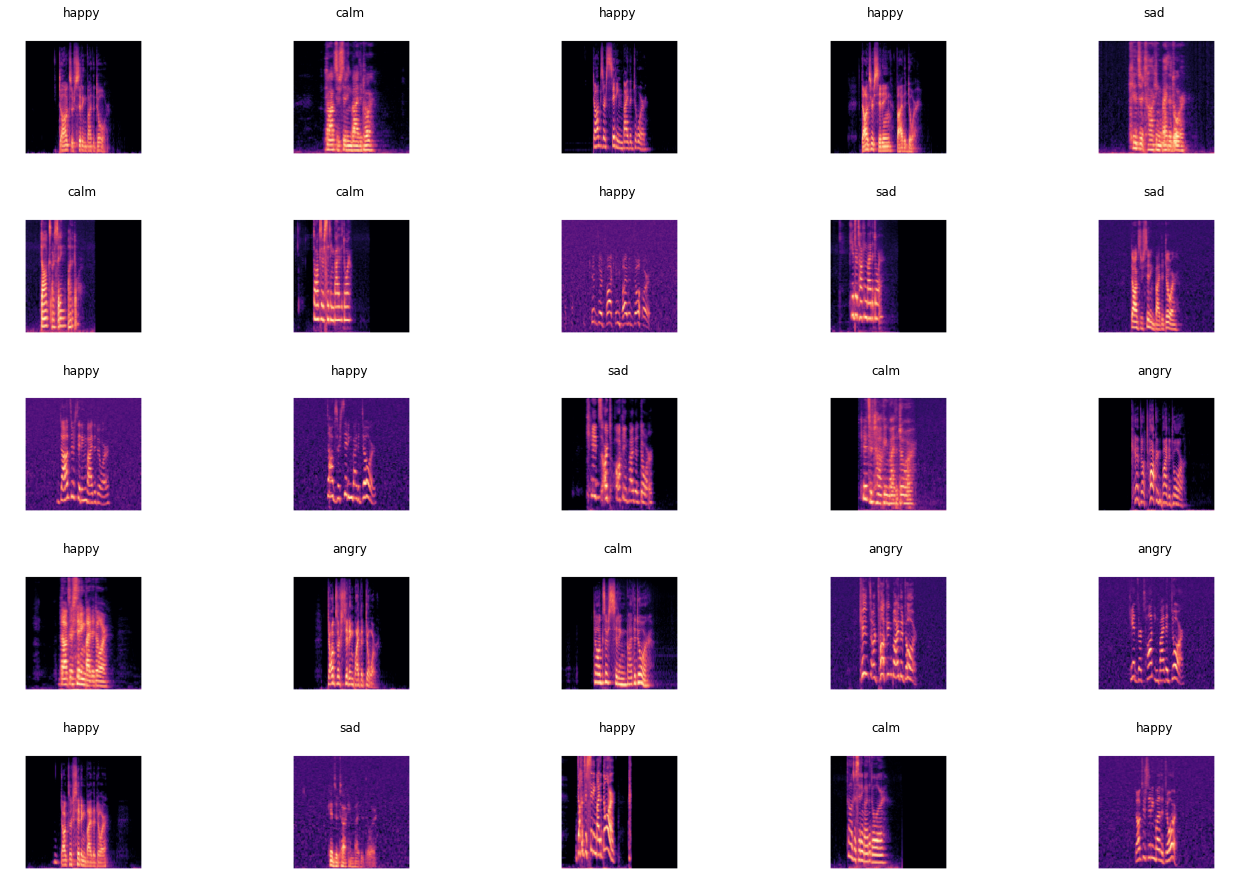

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_data))
        ax[i,j].imshow(train_data[rnd_number])
        ax[i,j].set_title((train_labels[rnd_number]))
        ax[i,j].axis('off')

Text(0.5, 1.0, 'Sample  calm')

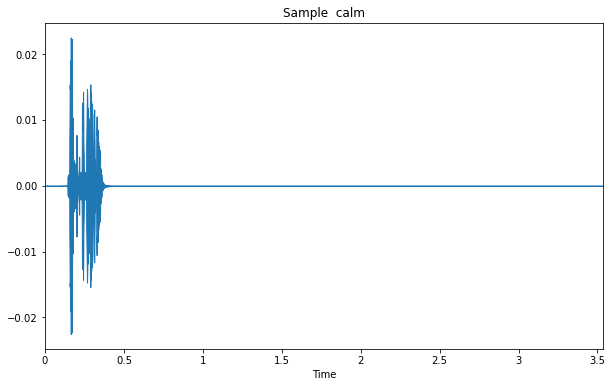

In [ ]:
plt.figure(figsize=(10,6))
librosa.display.waveplot(sample)
plt.title("Sample  "+ tes[0][2])


Text(0.5, 1.0, 'Sample  calm   noise')

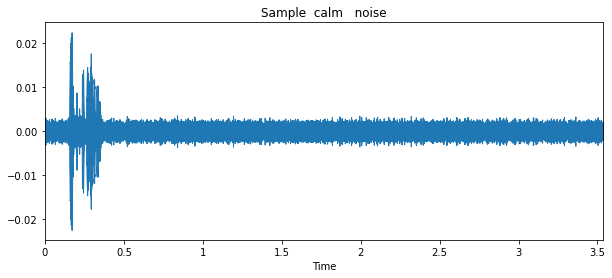

In [ ]:
plt.figure(figsize=(10,4))
librosa.display.waveplot(noise(sample))
plt.title("Sample  "+ tes[0][2]+ "   noise")


Text(0.5, 1.0, 'Sample  calm   speed n pitch')

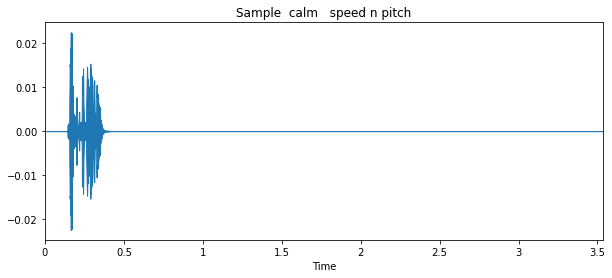

In [ ]:
plt.figure(figsize=(10,4))
librosa.display.waveplot(speedNpitch(sample))
plt.title("Sample  "+ tes[0][2]+ "   speed n pitch")

Text(0.5, 1.0, 'Sample  calm   speed n pitch')

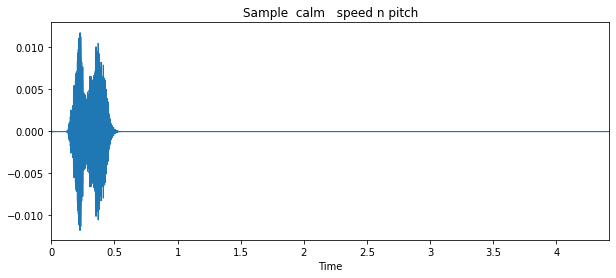

In [ ]:
plt.figure(figsize=(10,4))
librosa.display.waveplot(stretch(sample))
plt.title("Sample  "+ tes[0][2]+ "   speed n pitch")

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(train_data,train_labels,shuffle=True,test_size=0.33)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
print('X_train has a shape of {}, y_train has a shape of {}'.format(X_train.shape,y_train.shape))
print('X_test has a shape of {}, y_test has a shape of {}'.format(X_test.shape,y_test.shape))

X_train has a shape of (2058, 224, 224, 3), y_train has a shape of (2058,)
X_test has a shape of (1014, 224, 224, 3), y_test has a shape of (1014,)


In [ ]:
Le=LabelEncoder()


In [ ]:
y_train=Le.fit_transform(y_train)
y_test=Le.transform(y_test)

In [ ]:
train_data=load("train_data.npy")
train_labels=load("train_labels.npy")

In [ ]:
from numpy import load

In [ ]:

from keras.applications import VGG16

vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x) # Softmax for multiclass
transfer_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from tensorflow.keras import layers, models, Model, optimizers

learning_rate= 5e-5
transfer_model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

In [ ]:
history = transfer_model.fit(X_train, y_train, batch_size = 1, epochs=50, validation_data=(X_test,y_test))


Epoch 1/50
2058/2058 [==============================] - 51s 10ms/step - loss: 1.4423 - accuracy: 0.3134 - val_loss: 1.1313 - val_accuracy: 0.4527
Epoch 2/50
2058/2058 [==============================] - 20s 10ms/step - loss: 1.1818 - accuracy: 0.4431 - val_loss: 1.1119 - val_accuracy: 0.4714
Epoch 3/50
2058/2058 [==============================] - 20s 10ms/step - loss: 1.0938 - accuracy: 0.4881 - val_loss: 0.9900 - val_accuracy: 0.5306
Epoch 4/50
2058/2058 [==============================] - 20s 10ms/step - loss: 1.0587 - accuracy: 0.5049 - val_loss: 1.0117 - val_accuracy: 0.5128
Epoch 5/50
2058/2058 [==============================] - 20s 10ms/step - loss: 1.0006 - accuracy: 0.5550 - val_loss: 1.0034 - val_accuracy: 0.5661
Epoch 6/50
2058/2058 [==============================] - 20s 10ms/step - loss: 0.9754 - accuracy: 0.5517 - val_loss: 0.9070 - val_accuracy: 0.5927
Epoch 7/50
2058/2058 [==============================] - 20s 10ms/step - loss: 0.9125 - accuracy: 0.5950 - val_loss: 0.8659 -

In [ ]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

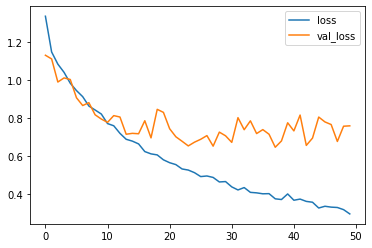

In [ ]:
pd.DataFrame(history.history)[["loss","val_loss"]].plot()

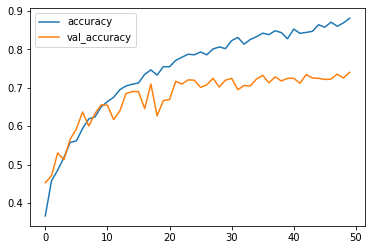

In [ ]:
pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()

In [ ]:
y_pred=Le.inverse_transform(np.argmax(transfer_model.predict(X_test),axis=1))

In [ ]:
y_true=Le.inverse_transform(y_test)

Confusion matrix, without normalization


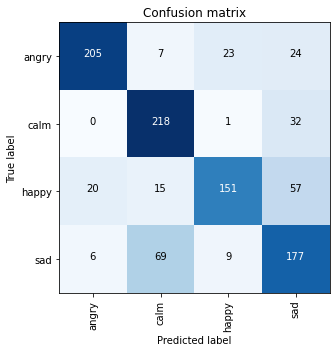

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true,y_pred),classes=Le.classes_,figname="vgg1woAug.png")
plt.plo

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.79      0.84       259
        calm       0.71      0.87      0.78       251
       happy       0.82      0.62      0.71       243
         sad       0.61      0.68      0.64       261

    accuracy                           0.74      1014
   macro avg       0.76      0.74      0.74      1014
weighted avg       0.76      0.74      0.74      1014



Added Image data generator...And callbacks

In [ ]:
from keras.applications import VGG16

m2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
for layer in m2.layers[:15]:
    layer.trainable = False

In [ ]:

x = m2.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x) # Softmax for multiclass
vgg_ai = Model(inputs=m2.input, outputs=x)

In [ ]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.95, 
                              min_lr=0.000001)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model2.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [ ]:

train_datagen = ImageDataGenerator( zoom_range=0.3,
                                   rotation_range=20,
                                   width_shift_range=0.15)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=1)

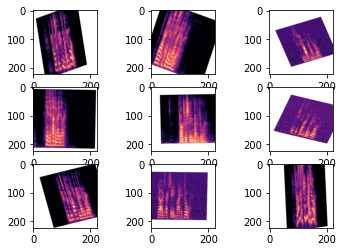

In [ ]:
img_rows, img_cols = 224, 224

for x, y in train_datagen.flow(X_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(x[i].reshape(img_rows, img_cols, 3))
    # show the plot
    pyplot.show()
    break

In [ ]:
!rm -rf ./logs/ 

In [ ]:
log_dir = "logs/fit/1" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
learning_rate= 5e-5
vgg_ai.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

history = vgg_ai.fit_generator(train_generator,
                    # steps_per_epoch=10,
                    validation_data=(X_test,y_test),
                    # validation_steps=20,
                    epochs=80,
                    callbacks=[lr_reduce,checkpoint,tensorboard_callback])
                    # shuffle=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
2058/2058 [==============================] - 37s 18ms/step - loss: 1.3613 - accuracy: 0.3214 - val_loss: 1.0771 - val_accuracy: 0.5079

Epoch 00001: val_accuracy improved from -inf to 0.50789, saving model to model2.h5
Epoch 2/80
2058/2058 [==============================] - 36s 17ms/step - loss: 1.0728 - accuracy: 0.4968 - val_loss: 0.9575 - val_accuracy: 0.5434

Epoch 00002: val_accuracy improved from 0.50789 to 0.54339, saving model to model2.h5
Epoch 3/80
2058/2058 [==============================] - 36s 17ms/step - loss: 0.9454 - accuracy: 0.5797 - val_loss: 0.8569 - val_accuracy: 0.6351

Epoch 00003: val_accuracy improved from 0.54339 to 0.63511, saving model to model2.h5
Epoch 4/80
2058/2058 [==============================] - 36s 17ms/step - loss: 0.8401 - accuracy: 0.6469 - val_loss: 0.7192 - val_accuracy: 0.7041

Epoch 00004: val_accuracy improved from 0.63511 to 0.70414, saving model to model2.h5
Epoch 5/80
2058/2058 [==============================] - 35s 17ms/step -

In [ ]:
y_train.shape

(2058,)

In [ ]:
y_test.shape

(1014,)

In [ ]:
m2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
y_pred=Le.inverse_transform(np.argmax(vgg_ai.predict(X_test),axis=1))

In [ ]:
y_true=Le.inverse_transform(y_test)

In [ ]:
accuracy_score(y_true,y_pred)

0.9092702169625246

In [ ]:
confusion_matrix(y_true,y_pred)

array([[244,   0,  13,   2],
       [  2, 236,   1,  12],
       [  5,   8, 212,  18],
       [  0,  20,  11, 230]])

Confusion matrix, without normalization


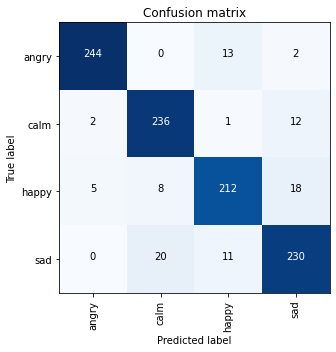

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true,y_pred),classes=Le.classes_,figname="best90.png")

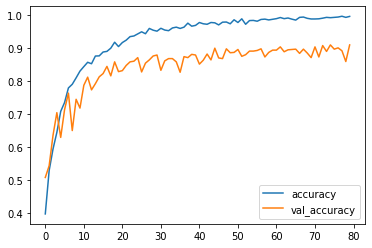

In [ ]:
pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()

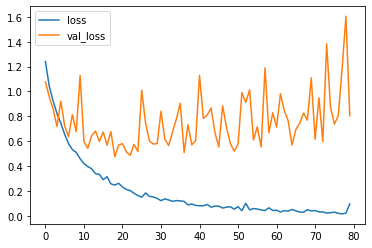

In [ ]:
pd.DataFrame(history.history)[["loss","val_loss"]].plot()

In [ ]:
%tensorboard --logdir logs/fit/1


<IPython.core.display.Javascript object>

In [ ]:
%load_ext tensorboard

In [3]:
# tf.keras.utils.plot_model(vgg_ai,show_shapes=True)

In [ ]:
/content/model2.h5

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

       angry       0.97      0.94      0.96       259
        calm       0.89      0.94      0.92       251
       happy       0.89      0.87      0.88       243
         sad       0.88      0.88      0.88       261

    accuracy                           0.91      1014
   macro avg       0.91      0.91      0.91      1014
weighted avg       0.91      0.91      0.91      1014

